In [1]:
# Importing necessary libraries 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [2]:
class Particle:
    """
    Class to represent a particle in 2D space with position, velocity, and mass.
    Can optionally represent a point as a black hole.
    """

    def __init__(self, position, velocity, mass=1.0, is_black_hole=False):
        """
        Initialize a new Particle.

        :param position: Initial 2D position [x, y].
        :type position: list or np.ndarray
        :param velocity: Initial 2D velocity [vx, vy].
        :type velocity: list or np.ndarray
        :param mass: Mass of the particle (default is 1.0).
        :type mass: float
        :param is_black_hole: Whether the particle is a black hole.
        :type is_black_hole: bool
        """
        self.position = np.array(position, dtype=float) # Convert position to NumPy array for vector ops
        self.velocity = np.array(velocity, dtype=float) # Convert velocity to NumPy array
        self.mass = mass # Set particle mass
        self.is_black_hole = is_black_hole # Flag indicating if this is a black hole

    def update(self, force, dt):
        """
        Update the particle's velocity and position based on an applied force and time step.

        :param force: Force vector acting on the particle [Fx, Fy].
        :type force: np.ndarray or list
        :param dt: Time step for the update.
        :type dt: float
        :return: None
        :rtype: None
        """
        # Acceleration from force using Newton's second law: F = ma
        acceleration = force / self.mass
        # Update velocity: v = v + a * dt
        self.velocity += acceleration * dt
        # Update position: x = x + v * dt
        self.position += self.velocity * dt

In [3]:
class TreeNode:
    """
    A node in a 2D Barnes-Hut quadtree for organizing particles and efficiently computing gravitational interactions 
    and orbital velocities.
    """

    def __init__(self, center, size):
        """
        Initialize a TreeNode with a center point and square size.

        :param center: The center of the node [x, y].
        :type center: list or np.ndarray
        :param size: The width/height of the node.
        :type size: float
        """
        self.center = np.array(center, dtype=float)  # Center coordinates of the node
        self.size = size  # Width/height of the square node
        self.mass = 0  # Total mass contained in this node
        self.center_of_mass = np.zeros(2)  # Center of mass of the node
        self.particle = None  # Holds a single particle if this is a leaf node
        self.children = [None, None, None, None]  # Children nodes: NW, NE, SW, SE
        self.num_particles = 0  # Count of particles contained in or under this node

    def get_quadrant(self, pos):
        """
        Determine which quadrant a position belongs to.

        :param pos: The 2D position [x, y].
        :return: Quadrant index (0=NW, 1=NE, 2=SW, 3=SE).
        """
        left = pos[0] < self.center[0]
        top = pos[1] >= self.center[1]
        if left and top:
            return 0  # Northwest
        elif not left and top:
            return 1  # Northeast
        elif left and not top:
            return 2  # Southwest
        else:
            return 3  # Southeast

    def create_subnode(self, quadrant):
        """
        Create a child node in the given quadrant.

        :param quadrant: Index of the quadrant to create (0=NW, 1=NE, 2=SW, 3=SE).
        """
        offset = self.size / 4
        # Compute new center based on quadrant
        if quadrant == 0:
            new_center = self.center + [-offset, offset]
        elif quadrant == 1:
            new_center = self.center + [offset, offset]
        elif quadrant == 2:
            new_center = self.center + [-offset, -offset]
        else:
            new_center = self.center + [offset, -offset]
        # Create child TreeNode
        self.children[quadrant] = TreeNode(new_center, self.size / 2)

    def insert(self, new_particle):
        """
        Insert a particle into the quadtree.

        :param new_particle: The particle to insert.
        """
        if not self.contains(new_particle.position):
            return  # Ignore particles outside the bounds of this node

        if self.num_particles == 0:
            # First particle in this node; store it directly
            self.particle = new_particle
        elif self.num_particles == 1:
            # This node becomes an internal node: redistribute the existing and new particles
            existing_particle = self.particle
            self.particle = None  # Clear current particle

            # Reinsert the existing particle into appropriate child
            quad = self.get_quadrant(existing_particle.position)
            if self.children[quad] is None:
                self.create_subnode(quad)
            self.children[quad].insert(existing_particle)

            # Insert the new particle
            quad = self.get_quadrant(new_particle.position)
            if self.children[quad] is None:
                self.create_subnode(quad)
            self.children[quad].insert(new_particle)
        else:
            # Node is already internal; just insert into appropriate child
            quad = self.get_quadrant(new_particle.position)
            if self.children[quad] is None:
                self.create_subnode(quad)
            self.children[quad].insert(new_particle)

        self.num_particles += 1  # Increment total particle count

    def contains(self, pos):
        """
        Check if a position is within the bounds of this node.

        :param pos: The position to check [x, y].
        :return: True if position is inside node bounds, else False.
        """
        half_size = self.size / 2
        return (self.center[0] - half_size <= pos[0] <= self.center[0] + half_size and
                self.center[1] - half_size <= pos[1] <= self.center[1] + half_size)

    def compute_mass_distribution(self):
        """
        Recursively compute total mass and center of mass for this node.
        """
        if self.num_particles == 1:
            # Leaf node: mass and center of mass from the single particle
            self.mass = self.particle.mass
            self.center_of_mass = self.particle.position.copy()
        else:
            # Internal node: compute total mass and weighted average of centers
            total_mass = 0
            weighted_position = np.zeros(2)
            for child in self.children:
                if child is not None and child.num_particles > 0:
                    child.compute_mass_distribution()
                    total_mass += child.mass
                    weighted_position += child.mass * child.center_of_mass
            self.mass = total_mass
            if total_mass > 0:
                self.center_of_mass = weighted_position / total_mass

    def calculate_force(self, target_particle, theta=0.5, G=6.6743e-11, softening=0.1):
        """
        Compute gravitational force on a particle using Barnes-Hut approximation.

        :param target_particle: The particle on which force is being calculated.
        :param theta: Opening angle threshold for approximation.
        :param G: Gravitational constant.
        :param softening: Small value to avoid singularities at small distances.
        :return: Net force vector on the target particle.
        """
        force = np.zeros(2)

        # Skip empty nodes and self-interaction
        if self.num_particles == 0 or (self.num_particles == 1 and self.particle is target_particle):
            return force

        r = self.center_of_mass - target_particle.position
        dist = np.linalg.norm(r) + softening  # Avoid division by zero

        if self.num_particles == 1 or (self.size / dist) < theta:
            # Use approximation: treat as single mass at center of mass
            force_mag = G * self.mass * target_particle.mass / (dist ** 2)
            force += force_mag * (r / dist)
        else:
            # Recurse into child nodes
            for child in self.children:
                if child is not None:
                    force += child.calculate_force(target_particle, theta, G, softening)

        return force

    def set_orbital_velocities(self, center_mass, center_position, G=6.6743e-11, clockwise=True):
        """
        Recursively assign circular orbital velocities to all non-black-hole particles.

        :param center_mass: Mass of central object.
        :param center_position: Position of central object [x, y].
        :param G: Gravitational constant.
        :param clockwise: Whether the orbit should be clockwise.
        """
        if self.num_particles == 1:
            p = self.particle
            if p.is_black_hole:
                return  # Do not assign velocity to central black hole

            r_vec = p.position - np.array(center_position)
            r = np.linalg.norm(r_vec)

            if r == 0:
                raise ValueError("Particle is at the center of mass! Cannot set orbital velocity.")

            # Compute magnitude of circular velocity
            v_mag = np.sqrt(G * center_mass / r)

            # Create a unit vector perpendicular to the radius vector
            tangent = np.array([-r_vec[1], r_vec[0]]) if clockwise else np.array([r_vec[1], -r_vec[0]])
            tangent /= np.linalg.norm(tangent)

            # Set orbital velocity
            p.velocity = v_mag * tangent
        else:
            # Recurse into children
            for child in self.children:
                if child is not None:
                    child.set_orbital_velocities(center_mass, center_position, G, clockwise)

In [4]:
class MainApp:
    """
    Main application class that runs an N-body simulation using the Barnes-Hut quadtree algorithm from 'TreeNode'.
    It manages the simulation domain, constructs the tree, and updates particle positions over time.
    """

    def __init__(self, domain_center, domain_size, particles):
        """
        Initialize the simulation.

        :param domain_center: Center of the simulation domain.
        :type domain_center: array-like of float
        :param domain_size: Size (width/height) of the square simulation domain.
        :type domain_size: float
        :param particles: List of Particle objects in the simulation.
        :type particles: list[Particle]
        """
        self.domain_center = np.array(domain_center, dtype=float)  # Store domain center 
        self.domain_size = domain_size  # Width/height of the simulation square
        self.particles = particles  # List of all particles in the simulation

    def build_tree(self):
        """
        Build a Barnes-Hut quadtree from the current set of particles.

        :return: Root node of the constructed quadtree.
        :rtype: TreeNode
        """
        root = TreeNode(self.domain_center, self.domain_size)  # Create root node for current domain
        for p in self.particles:
            root.insert(p)  # Insert each particle into the quadtree
        root.compute_mass_distribution()  # Compute mass and center-of-mass for internal nodes
        return root  # Return the constructed tree

    def run_simulation(self, num_steps=200, dt=0.1, theta=0.5):
        """
        Run the N-body simulation for a given number of time steps.

        :param num_steps: Number of simulation steps to run.
        :type num_steps: int
        :param dt: Time step size.
        :type dt: float
        :param theta: Opening angle threshold for Barnes-Hut approximation.
        :type theta: float
        :return: List of particle positions at each time step.
        :rtype: list[list[np.ndarray]]
        """
        positions_over_time = []  # Will store particle positions at each timestep

        for _ in range(num_steps):
            # Check if any particle has moved outside the current domain
            max_dist = max(np.linalg.norm(p.position - self.domain_center) for p in self.particles)
            if max_dist > self.domain_size / 2:
                self.domain_size = max_dist * 2  # Expand domain to ensure all particles are included

            tree = self.build_tree()  # Build quadtree for current particle positions

            forces = []
            for p in self.particles:
                f = tree.calculate_force(p, theta=theta)  # Compute force on particle using Barnes-Hut approximation
                forces.append(f)

            # Update particles based on computed forces
            for p, f in zip(self.particles, forces):
                p.update(f, dt)  # Update velocity and position using simple integrator

            # Save current positions for later analysis or plotting
            positions_over_time.append([p.position.copy() for p in self.particles])

        return positions_over_time  # Return the full trajectory history

In [5]:
# =====================================
# GALAXY COLLISION SIMULATION STARTS
# ===================================== 

# Big galaxy
big_galaxy = [
    Particle(position=[np.random.uniform(-1, 1), np.random.uniform(-1, 1)],
             velocity=[0, 0], mass=1e12, is_black_hole=True)
]

big_galaxy += [
    Particle(position=[np.random.uniform(-5, 5), np.random.uniform(-5, 5)],
             velocity=[0, 0], mass=1e6)
    for _ in range(250)
]

# Create TreeNode for big galaxy
big_tree = TreeNode(center=(0, 0), size=100)

# Insert all particles into the tree
for particle in big_galaxy:
    big_tree.insert(particle)

# Set orbital velocities for all particles in the big galaxy tree
big_tree.set_orbital_velocities(center_mass=big_galaxy[0].mass, center_position=big_galaxy[0].position)

# Small galaxy
small_galaxy = [
    Particle(position=[np.random.uniform(20, 22), np.random.uniform(20, 22)],
             velocity=[-0.5, 0], mass=1e8, is_black_hole=True)
]

small_galaxy += [
    Particle(position=[np.random.uniform(18, 24), np.random.uniform(18, 24)],
             velocity=[0, 0], mass=1e6)
    for _ in range(150)
]

# Create TreeNode for small galaxy
small_tree = TreeNode(center=(20, 20), size=10)

# Insert all particles into the small galaxy tree
for particle in small_galaxy:
    small_tree.insert(particle)

# Set orbital velocities for all particles in the small galaxy tree
small_tree.set_orbital_velocities(center_mass=small_galaxy[0].mass, center_position=small_galaxy[0].position)

# Combine
particles = big_galaxy + small_galaxy

# Initialize app
app = MainApp(domain_center=(0, 0), domain_size=100, particles=particles)

# Run simulation
positions = app.run_simulation(num_steps=200, dt=0.15, theta=0.5) 

Galaxy collision simulation complete. GIF saved as 'galaxy_collision_same_galaxy.gif'.


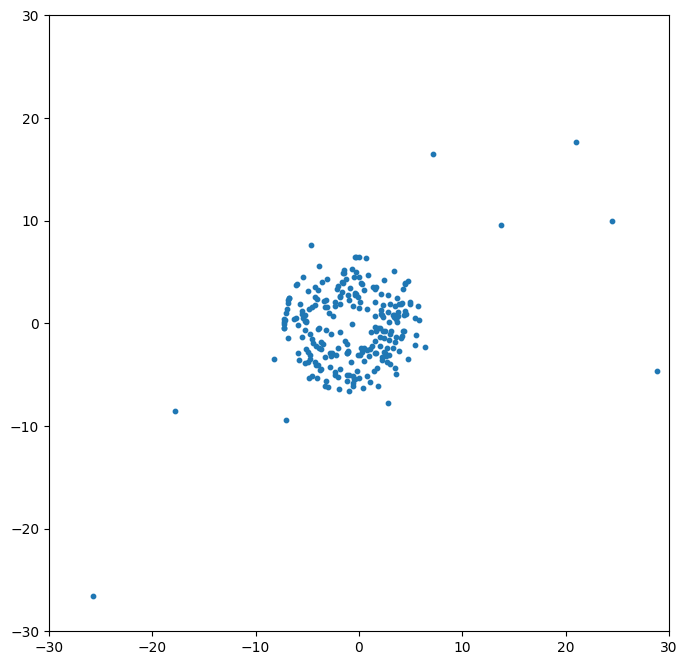

In [6]:
# =====================================
# Visualization
# This and the previous code is where you can play around with to get different results :) 
# =====================================

# Visualization
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(-30, 30)
ax.set_ylim(-30, 30)

initial_positions = np.array(positions[0])
scatter = ax.scatter(initial_positions[:, 0], initial_positions[:, 1], s=10)

def update(frame):
    """
    Update the scatter plot for a single frame of the animation.

    :param frame: Index of the current animation frame.
    :type frame: int
    :return: Tuple containing the updated scatter plot object.
    :rtype: tuple
    """
    # Update particle positions in the scatter plot
    positions_frame = np.array(positions[frame])
    scatter.set_offsets(positions_frame)
    return scatter,

ani = FuncAnimation(fig, update, frames=len(positions), interval=50, blit=True)

# Save the animation
ani.save('galaxy_collision_test_2.gif', writer='pillow')

print("Galaxy collision simulation complete. GIF saved as 'galaxy_collision_same_galaxy.gif'.")